In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# shap
import shap

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# imblearn for SMOTE
from imblearn.over_sampling import SMOTE

import pymc as pm
import arviz as az

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plays_df = pd.read_csv('./data/plays.csv')
player_play_df = pd.read_csv('./data/player_play.csv')
games_df = pd.read_csv('./data/games.csv')

In [3]:
plays_df.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,yardsGained,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone
0,2022102302,2655,(1:54) (Shotgun) J.Burrow pass short middle to...,3,1,10,CIN,ATL,CIN,21,...,9,0.004634,-0.004634,0.702717,True,NaN,NaN,0,Cover-3,Zone
1,2022091809,3698,(2:13) (Shotgun) J.Burrow pass short right to ...,4,1,10,CIN,DAL,CIN,8,...,4,0.002847,-0.002847,-0.240509,True,NaN,NaN,0,Quarters,Zone
2,2022103004,3146,(2:00) (Shotgun) D.Mills pass short right to D...,4,3,12,HOU,TEN,HOU,20,...,6,0.000205,-0.000205,-0.218480,True,NaN,NaN,0,Quarters,Zone
3,2022110610,348,(9:28) (Shotgun) P.Mahomes pass short left to ...,1,2,10,KC,TEN,TEN,23,...,4,-0.001308,0.001308,-0.427749,True,NaN,NaN,0,Quarters,Zone
4,2022102700,2799,(2:16) (Shotgun) L.Jackson up the middle to TB...,3,2,8,BAL,TB,TB,27,...,-1,0.027141,-0.027141,-0.638912,False,MAN,READ OPTION,0,Cover-1,Man


In [4]:
print(plays_df['playDescription'][0])

(1:54) (Shotgun) J.Burrow pass short middle to T.Boyd to CIN 30 for 9 yards (J.Hawkins).


In [5]:
player_play_df.head()

,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,hadDropback,passingYards,sackYardsAsOffense,hadPassReception,...,wasRunningRoute,routeRan,blockedPlayerNFLId1,blockedPlayerNFLId2,blockedPlayerNFLId3,pressureAllowedAsBlocker,timeToPressureAllowedAsBlocker,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId
0,2022090800,56,35472,BUF,0,0,0,0,0,0,...,NaN,NaN,47917.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,2022090800,56,42392,BUF,0,0,0,0,0,0,...,NaN,NaN,47917.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,2022090800,56,42489,BUF,0,0,0,0,0,1,...,1.0,IN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022090800,56,44875,BUF,0,0,0,0,0,0,...,NaN,NaN,43335.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,2022090800,56,44985,BUF,0,0,0,0,0,0,...,1.0,OUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
games_df.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2022090800,2022,1,9/8/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,9/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,9/11/2022,13:00:00,CAR,CLE,24,26
3,2022091102,2022,1,9/11/2022,13:00:00,CHI,SF,19,10
4,2022091103,2022,1,9/11/2022,13:00:00,CIN,PIT,20,23


In [7]:
def merge_dataset(plays_df, games_df):
    """
    Combine 2 datasets into one based on the gameId column, and perform
    data cleaning and feature engineering.
    """
    df = plays_df.merge(games_df, on='gameId', how='left')
    
    df['is_pass'] = df['isDropback'].astype(int)
    df['is_home_team'] = df['possessionTeam'] == df['homeTeamAbbr']
    
    df['score_differential'] = np.where(
        df['is_home_team'],
        df['preSnapHomeScore'] - df['preSnapVisitorScore'],
        df['preSnapVisitorScore'] - df['preSnapHomeScore']
    )
    
    print(f"Data set length: {len(df)}")
    print(df.info())
    
    return df

In [8]:
df = merge_dataset(plays_df, games_df)

Data set length: 16124
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16124 entries, 0 to 16123
Data columns (total 61 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   gameId                            16124 non-null  int64  
 1   playId                            16124 non-null  int64  
 2   playDescription                   16124 non-null  object 
 3   quarter                           16124 non-null  int64  
 4   down                              16124 non-null  int64  
 5   yardsToGo                         16124 non-null  int64  
 6   possessionTeam                    16124 non-null  object 
 7   defensiveTeam                     16124 non-null  object 
 8   yardlineSide                      15900 non-null  object 
 9   yardlineNumber                    16124 non-null  int64  
 10  gameClock                         16124 non-null  object 
 11  preSnapHomeScore                  16124 non-


Run/Pass Distribution:
is_pass
1    0.60382
0    0.39618
Name: proportion, dtype: float64


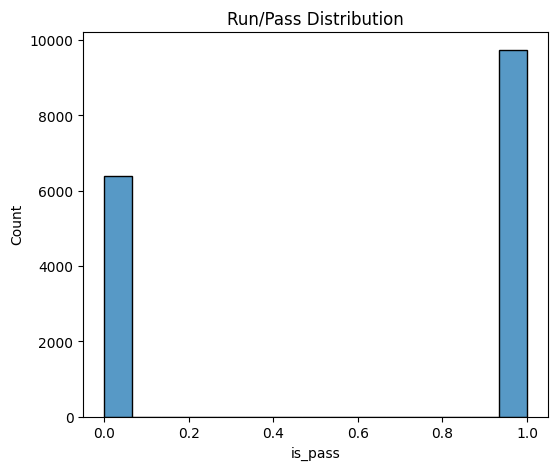

In [9]:
print("\nRun/Pass Distribution:")
print(df['is_pass'].value_counts(normalize=True))
plt.figure(figsize=(6, 5))
sns.histplot(df, x='is_pass', multiple='stack')
plt.title('Run/Pass Distribution')
plt.show()

In [10]:
# get combined tracking weeks csv
motion_features = pd.read_csv('./data/motion_features.csv') 
valid_plays = plays_df[['gameId', 'playId']].copy()
all_motion = []

# Create more granular motion features
motion_features['motion_frames'] = motion_features['s']  # Raw count of motion frames
motion_features['total_movement'] = motion_features['x']  # Raw movement distance

# Create numerical motion levels (0-3)
motion_features['motion_level'] = pd.cut(motion_features['s'],
                                       bins=[-float('inf'), 0, 3, 6, float('inf')],
                                       labels=[0, 1, 2, 3]).astype(float)

# Calculate motion intensity (movement per frame with motion)
motion_features['motion_intensity'] = motion_features['x'] / motion_features['s'].clip(lower=1)

# Create binary flags with adjusted thresholds
motion_features['has_motion'] = (motion_features['s'] >= 2).astype(float)
motion_features['significant_movement'] = (motion_features['x'] > 1.5).astype(float)
motion_features['high_intensity'] = (motion_features['motion_intensity'] > 0.3).astype(float)

# Merge with valid plays
final_motion = motion_features.merge(valid_plays, on=['gameId', 'playId'], how='right')

print(f"Total plays processed: {len(final_motion)}")
print(f"Plays with motion: {final_motion['has_motion'].sum()}")
print(f"Plays with significant movement: {final_motion['significant_movement'].sum()}")
print(f"Plays with high intensity motion: {final_motion['high_intensity'].sum()}")
print(final_motion['motion_level'].value_counts(normalize=True))

Total plays processed: 16124
Plays with motion: 143.0
Plays with significant movement: 20.0
Plays with high intensity motion: 173.0
motion_level
0.0    0.772490
1.0    0.211213
2.0    0.011734
3.0    0.004563
Name: proportion, dtype: float64


The s value represents the count of frames where a player had significant movement (speed > 0.62) in the last 10 frames before the snap. Since we're looking at 10 frames total, s would range from 0-10.

In [11]:
# merge with original features
final_motion = final_motion.fillna(0)
print(final_motion.columns)
df = df.merge(final_motion[['gameId', 'playId', 'has_motion', 'significant_movement', 'motion_level', 'motion_frames', 'total_movement', 'motion_intensity', 'playDirection']], 
                                    on=['gameId', 'playId'])

Index(['Unnamed: 0', 'gameId', 'playId', 's', 'x', 'playDirection',
       'motion_frames', 'total_movement', 'motion_level', 'motion_intensity',
       'has_motion', 'significant_movement', 'high_intensity'],
      dtype='object')



Motion Statistics by Play Type:
         has_motion  significant_movement  motion_intensity
is_pass                                                    
0          0.007044              0.001409          0.010127
1          0.010066              0.001130          0.010150


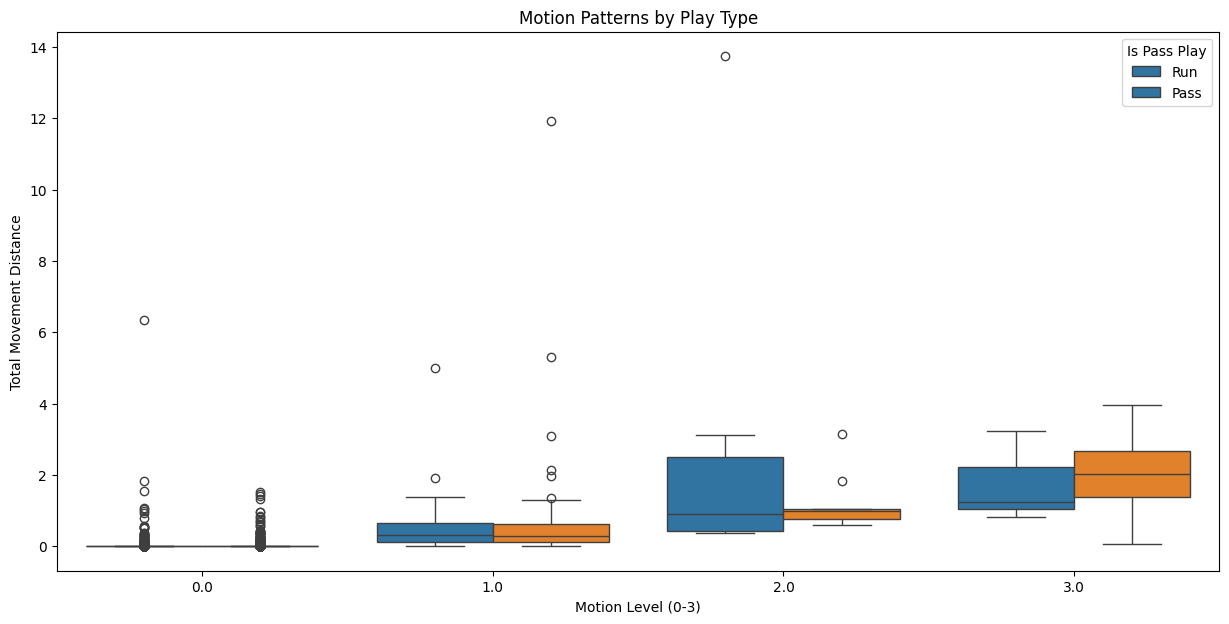

In [12]:
plt.figure(figsize=(15, 7))
sns.boxplot(data=df, x='motion_level', y='total_movement', hue='is_pass')
plt.title('Motion Patterns by Play Type')
plt.xlabel('Motion Level (0-3)')
plt.ylabel('Total Movement Distance')
plt.legend(title='Is Pass Play', labels=['Run', 'Pass'])

# Print some summary statistics
print("\nMotion Statistics by Play Type:")
print(df.groupby('is_pass')[['has_motion', 'significant_movement', 'motion_intensity']].mean())

In [13]:
def create_situational_features(df):
    """
    Create situational features related to down, distance, field position and time
    """
    feature_df = df.copy()
    feature_df = pd.get_dummies(feature_df, columns=['down'], prefix='down')
    
    # Distance situations
    feature_df['distance_short'] = feature_df['yardsToGo'] <= 3
    feature_df['distance_long'] = feature_df['yardsToGo'] >= 7
    feature_df['is_third_and_long'] = (feature_df['down_3'] == 1) & feature_df['distance_long']
    
    # Normalize yard line (0 = own goal line, 100 = opponent goal line)
    feature_df['yards_to_goal'] = np.where(
        feature_df['playDirection'] == 'right',        # right is own team's side
        100 - feature_df['absoluteYardlineNumber'],
        feature_df['absoluteYardlineNumber']
    )
    feature_df['in_redzone'] = feature_df['yards_to_goal'] <= 20
    feature_df['backed_up'] = feature_df['absoluteYardlineNumber'] <= 10
    
    # Convert game clock to seconds remaining in quarter
    feature_df['game_clock_seconds'] = feature_df['gameClock'].apply(
        lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1])
    )
    
    # End of half situations (last 2 minutes)
    feature_df['end_of_half'] = (feature_df['quarter'].isin([2, 4])) & \
                               (feature_df['game_clock_seconds'] <= 120)
    
    # scoring situation features 
    feature_df['score_differential_bucket'] = pd.cut(
        feature_df['score_differential'],
        bins=[-28, -17, -9, -3, 3, 9, 17, 28],
        labels=['big_deficit', 'medium_deficit', 'small_deficit', 
                'close', 'small_lead', 'medium_lead', 'big_lead']
    )
    
    feature_df['time_remaining_half'] = feature_df.apply(lambda x: 
        1800 if x['quarter'] <= 2 else 3600 - x['game_clock_seconds'], axis=1)
    
     # One-hot encoded downs, week, quarter
    feature_df = pd.get_dummies(feature_df, columns=['quarter'], prefix='quarter')
    
    # Win probability features
    feature_df['win_prob_differential'] = feature_df['preSnapHomeTeamWinProbability'] - feature_df['preSnapVisitorTeamWinProbability']
    
    return feature_df

In [14]:
# Apply the features
df_with_features = create_situational_features(df)

# Let's examine our new features
print("Situational features created:")
situational_features = [col for col in df_with_features.columns if col not in df.columns]
print("\n".join(situational_features))

Situational features created:
down_1
down_2
down_3
down_4
distance_short
distance_long
is_third_and_long
yards_to_goal
in_redzone
backed_up
game_clock_seconds
end_of_half
score_differential_bucket
time_remaining_half
quarter_1
quarter_2
quarter_3
quarter_4
quarter_5
win_prob_differential


In [15]:
# Quick validation
print("\nFeature Statistics:")
for feature in situational_features:
    if df_with_features[feature].dtype in ['int64', 'float64']:
        print(f"\n{feature}:")
        print(df_with_features[feature].describe())


Feature Statistics:

yards_to_goal:
count    16124.000000
mean        59.457021
std         24.713579
min         -9.000000
25%         40.000000
50%         60.000000
75%         80.000000
max        109.000000
Name: yards_to_goal, dtype: float64

game_clock_seconds:
count    16124.000000
mean       430.040995
std        271.988113
min          1.000000
25%        181.000000
50%        420.000000
75%        667.000000
max        900.000000
Name: game_clock_seconds, dtype: float64

time_remaining_half:
count    16124.000000
mean      2490.580191
std        709.386211
min       1800.000000
25%       1800.000000
50%       2700.000000
75%       3185.000000
max       3599.000000
Name: time_remaining_half, dtype: float64

win_prob_differential:
count    16124.000000
mean         0.104015
std          0.581206
min         -0.997901
25%         -0.350775
50%          0.157844
75%          0.583201
max          0.998393
Name: win_prob_differential, dtype: float64


In [16]:
# Check relationship with target
print("\nPass Play Percentage by Situation:")
situations = [
    ('is_third_and_long', 'Third and Long'),
    ('in_redzone', 'Red Zone'),
    ('end_of_half', 'End of Half'),
]

for col, label in situations:
    pass_pct = df_with_features[df_with_features[col]][['is_pass']].mean()
    print(f"\n{label}: {pass_pct['is_pass']:.3f}")


Pass Play Percentage by Situation:

Third and Long: 0.920

Red Zone: 0.531

End of Half: 0.709


In [17]:
# Validation checks
print("Null values:", df_with_features[situational_features].isnull().sum().sum())

Null values: 163


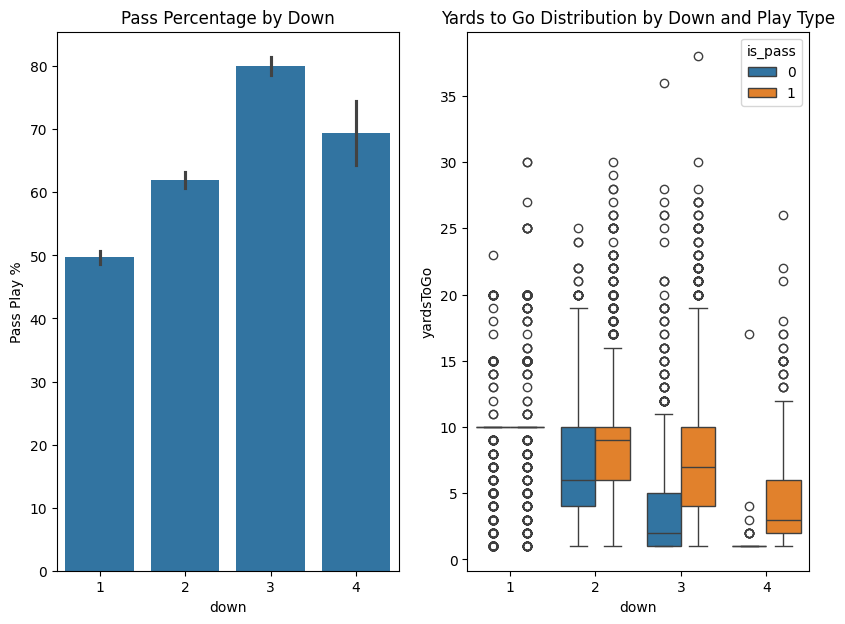

In [18]:
plt.figure(figsize=(15, 7))
plt.subplot(131)
sns.barplot(data=df, x='down', y='is_pass', 
            errorbar=('ci', 95), estimator=lambda x: sum(x)/len(x)*100)
plt.title('Pass Percentage by Down')
plt.ylabel('Pass Play %')

plt.subplot(132)
sns.boxplot(data=df, x='down', y='yardsToGo', hue='is_pass')
plt.title('Yards to Go Distribution by Down and Play Type')

plt.show()

In [19]:
print("Available columns:")
print(df_with_features.columns.tolist())

Available columns:
['gameId', 'playId', 'playDescription', 'yardsToGo', 'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore', 'playNullifiedByPenalty', 'absoluteYardlineNumber', 'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'expectedPoints', 'offenseFormation', 'receiverAlignment', 'playClockAtSnap', 'passResult', 'passLength', 'targetX', 'targetY', 'playAction', 'dropbackType', 'dropbackDistance', 'passLocationType', 'timeToThrow', 'timeInTackleBox', 'timeToSack', 'passTippedAtLine', 'unblockedPressure', 'qbSpike', 'qbKneel', 'qbSneak', 'rushLocationType', 'penaltyYards', 'prePenaltyYardsGained', 'yardsGained', 'homeTeamWinProbabilityAdded', 'visitorTeamWinProbilityAdded', 'expectedPointsAdded', 'isDropback', 'pff_runConceptPrimary', 'pff_runConceptSecondary', 'pff_runPassOption', 'pff_passCoverage', 'pff_manZone', 'season', 'week', 'gameDate', 'gameTimeEastern', 'homeTeamAbbr', 'visitorTeamA

In [20]:
def create_formation_features(df):
    """
    Create features based on offensive formation and receiver alignment
    """
    feature_df = df.copy()
    feature_df['offenseFormation'] = feature_df['offenseFormation'].fillna('UNKNOWN')
    
    # One-hot encode base formation
    feature_df = pd.get_dummies(feature_df, columns=['offenseFormation'], prefix='formation')
    
    # Clean and process receiver alignment
    feature_df['receiverAlignment'] = feature_df['receiverAlignment'].fillna('0x0')
    
    # Extract receiver alignment (3x2 is 3 left 2 right)
    alignment_split = feature_df['receiverAlignment'].str.extract(r'(\d)x(\d)')
    feature_df['receivers_left'] = pd.to_numeric(alignment_split[0], errors='coerce').fillna(0)
    feature_df['receivers_right'] = pd.to_numeric(alignment_split[1], errors='coerce').fillna(0)
    
    # Total receivers wide
    feature_df['total_receivers_wide'] = feature_df['receivers_left'] + feature_df['receivers_right']
    
    # Balanced/Unbalanced formation
    feature_df['is_balanced'] = feature_df['receivers_left'] == feature_df['receivers_right']
    
    # Empty backfield (5 or more receivers wide, then backfield is empty)
    feature_df['is_empty'] = feature_df['total_receivers_wide'] >= 5
    
    # Shotgun vs Under Center (from playDescription)
    feature_df['is_no_huddle'] = feature_df['playDescription'].str.contains('No Huddle', case=False, na=False)
    
    # Heavy personnel (based on receiver count)
    feature_df['is_heavy_formation'] = feature_df['total_receivers_wide'] <= 2
    feature_df['is_light_formation'] = feature_df['total_receivers_wide'] >= 4
    
    # Trips indicator (3 receivers to one side)
    feature_df['has_trips'] = (feature_df['receivers_left'] == 3) | (feature_df['receivers_right'] == 3)
    
    return feature_df

In [21]:
# Apply the formation features
df_with_formations = create_formation_features(df_with_features)
formation_features = [col for col in df_with_formations.columns if col not in df_with_features.columns]
print(len(formation_features))

17


In [22]:
# Basic analysis
print("\nFormation Distribution:")
for col in formation_features:
    if df_with_formations[col].dtype in ['int64', 'float64', 'bool']:
        pass_rate = df_with_formations[df_with_formations[col] == 1]['is_pass'].mean()
        count = df_with_formations[col].sum()
        print(f"\n{col}:")
        print(f"Count: {count}")
        print(f"Pass rate: {pass_rate:.3f}")


Formation Distribution:

formation_EMPTY:
Count: 1342
Pass rate: 0.965

formation_I_FORM:
Count: 1035
Pass rate: 0.289

formation_JUMBO:
Count: 125
Pass rate: 0.168

formation_PISTOL:
Count: 641
Pass rate: 0.353

formation_SHOTGUN:
Count: 8791
Pass rate: 0.745

formation_SINGLEBACK:
Count: 3915
Pass rate: 0.334

formation_UNKNOWN:
Count: 188
Pass rate: 0.122

formation_WILDCAT:
Count: 87
Pass rate: 0.149

receivers_left:
Count: 39250
Pass rate: 0.250

receivers_right:
Count: 23592
Pass rate: 0.565

total_receivers_wide:
Count: 62842
Pass rate: 0.125

is_balanced:
Count: 6832
Pass rate: 0.582

is_empty:
Count: 1363
Pass rate: 0.954

is_no_huddle:
Count: 1691
Pass rate: 0.699

is_heavy_formation:
Count: 401
Pass rate: 0.182

is_light_formation:
Count: 13890
Pass rate: 0.650

has_trips:
Count: 7286
Pass rate: 0.686


In [23]:
# Validation checks
print("Null values:",df_with_formations[formation_features].isnull().sum().sum())

Null values: 0


In [24]:
import numpy as np

def create_historical_tendencies(df):
    """
    Create basic historical tendency features using only prior information
    """
    feature_df = df.copy()
    feature_df = feature_df.sort_values(['gameId', 'playId'])
    
    # Overall team pass tendency (last 20 plays)
    feature_df['team_pass_tendency'] = feature_df.groupby('possessionTeam')['is_pass'].transform(
        lambda x: x.rolling(window=20, min_periods=1).mean().shift(1).fillna(x.mean())
    )
    # Last 3 plays
    feature_df['recent_tendency'] = feature_df.groupby('possessionTeam')['is_pass'].transform(
        lambda x: x.rolling(window=3, min_periods=1).mean().shift(1).fillna(x.mean())
    )
    # Team tendency
    feature_df['team_overall_pass_tendency'] = feature_df.groupby('possessionTeam')['is_pass'].transform('mean')
    # Situational tendencies
    feature_df['down_distance_pass_tendency'] = feature_df.groupby(['down_1', 'down_2', 'down_3', 'down_4', 'distance_short', 'distance_long'])['is_pass'].transform('mean')
    
    return feature_df

In [25]:
# Apply historical tendency features
df_with_tendencies = create_historical_tendencies(df_with_formations)

In [26]:
tendency_features = ['team_pass_tendency', 'recent_tendency', 'team_overall_pass_tendency', 'down_distance_pass_tendency']

# Check correlation with actual play calls
print("\nCorrelations with is_pass:")
correlations = df_with_tendencies[tendency_features].corrwith(df_with_tendencies['is_pass'])
print(correlations.sort_values(ascending=False))


Correlations with is_pass:
down_distance_pass_tendency    0.331796
team_overall_pass_tendency     0.131967
team_pass_tendency             0.126212
recent_tendency                0.105501
dtype: float64


In [27]:
def get_combined_features(df):
   # Formation interactions with down
   for down in [1,2,3,4]:
       df[f'formation_EMPTY_down_{down}'] = (df['formation_EMPTY'] == 1) & (df[f'down_{down}'] == 1)
       df[f'formation_SHOTGUN_down_{down}'] = (df['formation_SHOTGUN'] == 1) & (df[f'down_{down}'] == 1)
       
   # Receiver combinations
   df['receivers_ratio'] = df['total_receivers_wide'] / (df['receivers_left'] + df['receivers_right'] + 1)
   df['receiver_balance'] = abs(df['receivers_left'] - df['receivers_right'])
   
   # Distance and down interactions
   # Using one-hot encoded down columns
   df['critical_distance'] = ((df['down_3'] == 1) | (df['down_4'] == 1)) & (df['yardsToGo'] <= 3)
   df['long_distance'] = df['yardsToGo'] > 10
   
   # Time pressure features
   df['end_quarter_pressure'] = (df['game_clock_seconds'] < 120) & ((df['quarter_2'] == 1) | (df['quarter_4'] == 1))
   
   # Formation complexity
   df['complex_formation'] = df['total_receivers_wide'] > 3
   
   return df

In [28]:
def get_personnel_features(df, player_plays_df):
    # Create a copy of input dataframe
    personnel_features = df.copy()
    
    # Merge player positions from players.csv
    players_df = pd.read_csv('data/players.csv')
    player_plays_with_pos = player_plays_df.merge(players_df[['nflId', 'position']], 
                                                on='nflId', how='left')
    
    # Position counts per play
    position_counts = player_plays_with_pos.groupby(['gameId', 'playId', 'position']).size().unstack(fill_value=0)
    
    # Reset index to merge with main dataframe
    position_counts = position_counts.reset_index()
    
    # Merge position counts with main features
    personnel_features = personnel_features.merge(position_counts, on=['gameId', 'playId'], how='left')
    
    # Fill NaN values with 0 for position counts
    for pos in ['RB', 'TE', 'WR', 'FB']:
        if pos in personnel_features.columns:
            personnel_features[f'{pos}_count'] = personnel_features[pos].fillna(0)
        else:
            personnel_features[f'{pos}_count'] = 0
    
    # Calculate ratios and packages
    personnel_features['heavy_package'] = (personnel_features['TE_count'] + personnel_features['FB_count']) >= 2
    personnel_features['spread_formation'] = personnel_features['WR_count'] >= 3
    personnel_features['te_wr_ratio'] = personnel_features['TE_count'] / (personnel_features['WR_count'] + 1)
    
    # Situational features
    personnel_features['goal_line'] = personnel_features['absoluteYardlineNumber'] <= 5
    personnel_features['short_yardage'] = personnel_features['yardsToGo'] <= 3
    
    return personnel_features

In [29]:
def prepare_final_features(df):
    """
    Combine all relevant features into final modeling dataset
    Keep only the most important predictive features
    """
    features_df = df.copy()
    
    # Apply combined features
    features_df = get_combined_features(features_df)
    
    # Apply personnel features
    features_df = get_personnel_features(features_df, player_play_df)
    
    # Basic features
    basic_features = [
        'down_1', 'down_2', 'down_3', 'down_4',
        'yardsToGo',
        'absoluteYardlineNumber',
        'quarter_1',
        'quarter_2',
        'quarter_3',
        'quarter_4',
        'quarter_5',
    ]
    
    # Motion features  
    motion_features = [
        'has_motion', 'significant_movement', 'motion_level',
        'motion_frames', 'total_movement', 'motion_intensity'
    ]
    
    # Tendency features
    tendency_features = [
        'team_pass_tendency', 'recent_tendency',
        'team_overall_pass_tendency', 'down_distance_pass_tendency'
    ]
    
    # Situational features
    situational_features = [
        'distance_short', 'distance_long', 'is_third_and_long',
        'yards_to_goal', 'in_redzone', 'backed_up',
        'game_clock_seconds', 'end_of_half',
        'time_remaining_half', 'win_prob_differential', 
        'score_differential',
        'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability'
    ]
    
    # Combined features
    combined_features = [
        'formation_EMPTY_down_1', 'formation_EMPTY_down_2', 
        'formation_EMPTY_down_3', 'formation_EMPTY_down_4',
        'formation_SHOTGUN_down_1', 'formation_SHOTGUN_down_2',
        'formation_SHOTGUN_down_3', 'formation_SHOTGUN_down_4',
        'receivers_ratio', 'receiver_balance',
        'critical_distance', 'long_distance',
        'end_quarter_pressure', 'complex_formation'
    ]
    
    # Personnel features
    personnel_features = [
        'RB_count', 'TE_count', 'WR_count', 'FB_count',
        'heavy_package', 'spread_formation', 'te_wr_ratio',
        'goal_line', 'short_yardage'
    ]
    
    feature_columns = (basic_features + formation_features
        + motion_features + tendency_features 
        + situational_features + combined_features
        + personnel_features)
    
    # final feature set
    X = features_df[feature_columns]
    y = features_df['is_pass']
    
    # check feature set
    print("Final feature set:")
    print(X.columns.tolist())
    print("\nFeature set shape:", X.shape)
    print("\nClass distribution:")
    print(y.value_counts(normalize=True))
    
    return X, y, features_df[feature_columns]

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [46]:
# Create final feature set
X, y, train_df = prepare_final_features(df_with_tendencies)

Final feature set:
['down_1', 'down_2', 'down_3', 'down_4', 'yardsToGo', 'absoluteYardlineNumber', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'quarter_5', 'formation_EMPTY', 'formation_I_FORM', 'formation_JUMBO', 'formation_PISTOL', 'formation_SHOTGUN', 'formation_SINGLEBACK', 'formation_UNKNOWN', 'formation_WILDCAT', 'receivers_left', 'receivers_right', 'total_receivers_wide', 'is_balanced', 'is_empty', 'is_no_huddle', 'is_heavy_formation', 'is_light_formation', 'has_trips', 'has_motion', 'significant_movement', 'motion_level', 'motion_frames', 'total_movement', 'motion_intensity', 'team_pass_tendency', 'recent_tendency', 'team_overall_pass_tendency', 'down_distance_pass_tendency', 'distance_short', 'distance_long', 'is_third_and_long', 'yards_to_goal', 'in_redzone', 'backed_up', 'game_clock_seconds', 'end_of_half', 'time_remaining_half', 'win_prob_differential', 'score_differential', 'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'formation_EMPTY_down_1

c:\Users\909ca\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\909ca\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


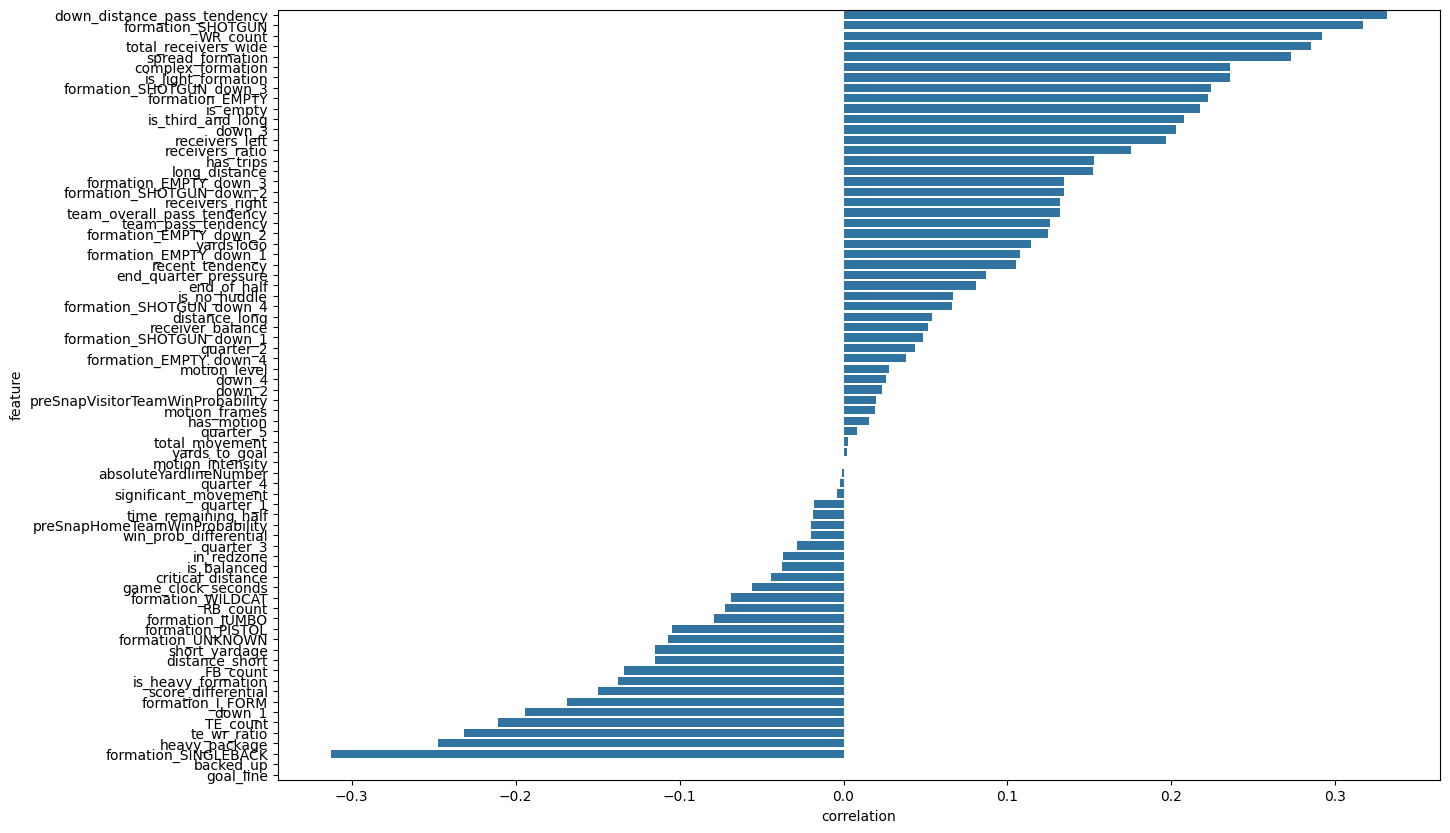

In [48]:
# Quick look at feature correlations with target
correlations = pd.DataFrame({
    'feature': X.columns,
    'correlation': X.corrwith(y)
}).sort_values('correlation', ascending=False)

# Remove any duplicate feature names that could cause reindexing issues
correlations = correlations[~correlations['feature'].duplicated()]
plt.figure(figsize=(15, 10))
sns.barplot(x='correlation', y='feature', data=correlations, orient='h')
plt.show()

In [477]:
# Helper Dataset class
class PlayPredictionDataset(Dataset):
    def __init__(self, features, targets, sample_weights=None):
        self.features = torch.FloatTensor(features)
        if hasattr(targets, 'values'):
            targets = targets.values
        self.targets = torch.FloatTensor(targets)
        if sample_weights is not None:
            self.sample_weights = torch.FloatTensor(sample_weights)
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [478]:
# First split the data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
)
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Create datasets
train_dataset = PlayPredictionDataset(X_train_scaled, y_train)
val_dataset = PlayPredictionDataset(X_val_scaled, y_val)

In [504]:
import torch
import torch.nn as nn

class PlayCNN(nn.Module):
    def __init__(self, num_features=X_train.shape[1]):
        super(PlayCNN, self).__init__()
        self.num_features = num_features
        
        # Convolutional blocks
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                     out_channels=64, 
                     kernel_size=(3,1),  # 3x1 kernel moving vertically
                     padding=(1,0)),     # Padding to maintain feature dim
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Calculate flattened size
        self.flat_features = 64 * num_features * 1
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.flat_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
        )
        
    def forward(self, x):
        # Reshape input to (batch_size, channels, height, width)
        x = x.view(-1, 1, self.num_features, 1)
        
        # Convolutional blocks
        x = self.conv_block1(x)
        
        # Flatten for classifier
        x = x.view(-1, self.flat_features)
        x = self.classifier(x)
        return x
    

In [524]:
# Calculate class weights
n_runs = (y_train == 0).sum()
n_passes = (y_train == 1).sum()

# Increase weight for passes to reduce false negatives
# Try a larger multiplier (e.g., 1.5 or 2.0) to penalize missed passes more
weight_multiplier = 1.5
pos_weight = torch.tensor([n_runs / n_passes * weight_multiplier]).to(device)

print(f"Original weight would be: {n_runs / n_passes:.3f}")
print(f"Adjusted weight: {pos_weight.item():.3f}")
# Update loss function with weights

model = PlayCNN(num_features=X_train_scaled.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

Original weight would be: 0.650
Adjusted weight: 0.975


In [525]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Initialize model with adjusted parameters
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min', 
    factor=0.1,
    patience=5,
    min_lr=1e-6,
    verbose=True
)

c:\Users\909ca\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [526]:
from torchinfo import summary
# model summary
sample_input = torch.randn(1, X_train_scaled.shape[1]).to(device)
model_summary = summary(model, input_size=(1, X_train_scaled.shape[1]), device=device, verbose=2)

Layer (type:depth-idx)                   Output Shape              Param #
PlayCNN                                  [1, 1]                    --
├─Sequential: 1-1                        [1, 64, 74, 1]            --
│    └─0.weight                                                    ├─192
│    └─0.bias                                                      ├─64
│    └─1.weight                                                    ├─64
│    └─1.bias                                                      └─64
│    └─Conv2d: 2-1                       [1, 64, 74, 1]            256
│    │    └─weight                                                 ├─192
│    │    └─bias                                                   └─64
│    └─BatchNorm2d: 2-2                  [1, 64, 74, 1]            128
│    │    └─weight                                                 ├─64
│    │    └─bias                                                   └─64
│    └─ReLU: 2-3                         [1, 64, 74, 1]          

In [527]:
best_val_auc = 0
patience = 5
patience_counter = 0
epochs = 40

# Training history
train_losses = []
val_losses = []
val_aucs = []
for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0
    
    # early stopping
    early_stopping_patience = 2
    best_val_loss = float('inf')
    early_stopping_counter = 0
    
    for features, targets in train_loader:
        features, targets = features.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.9)
        
        optimizer.step() 
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    predictions = []
    true_values = []
    
    with torch.no_grad():
        for features, targets in val_loader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            val_loss += criterion(outputs, targets.unsqueeze(1)).item()
                
            predictions.extend(outputs.cpu().numpy())
            true_values.extend(targets.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_auc = roc_auc_score(true_values, predictions)
    val_aucs.append(val_auc)
    
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        # Save best model
        torch.save(model.state_dict(), './models/best_model.pth')
    else:
        early_stopping_counter += 1
        
    if early_stopping_counter >= early_stopping_patience:
        print(f'Early stopping triggered after {epoch+1} epochs')
        break
    
    print(f'Epoch [{epoch+1}/{epochs}] | tr_loss ({avg_train_loss:.4f}) | val_loss ({avg_val_loss:.4f})')
    print(f'ROC / AUC: {val_auc:.4f} | lr: {current_lr:.6f}')
    print('------------------------')

Epoch [1/40] | tr_loss (0.5173) | val_loss (0.4875)
ROC / AUC: 0.8300 | lr: 0.001000
------------------------
Epoch [2/40] | tr_loss (0.4950) | val_loss (0.4828)
ROC / AUC: 0.8345 | lr: 0.001000
------------------------
Epoch [3/40] | tr_loss (0.4886) | val_loss (0.4811)
ROC / AUC: 0.8349 | lr: 0.001000
------------------------
Epoch [4/40] | tr_loss (0.4858) | val_loss (0.4757)
ROC / AUC: 0.8389 | lr: 0.001000
------------------------
Epoch [5/40] | tr_loss (0.4815) | val_loss (0.4792)
ROC / AUC: 0.8358 | lr: 0.001000
------------------------
Epoch [6/40] | tr_loss (0.4841) | val_loss (0.4756)
ROC / AUC: 0.8383 | lr: 0.001000
------------------------
Epoch [7/40] | tr_loss (0.4769) | val_loss (0.4750)
ROC / AUC: 0.8385 | lr: 0.001000
------------------------
Epoch [8/40] | tr_loss (0.4750) | val_loss (0.4752)
ROC / AUC: 0.8397 | lr: 0.001000
------------------------
Epoch [9/40] | tr_loss (0.4761) | val_loss (0.4785)
ROC / AUC: 0.8389 | lr: 0.001000
------------------------
Epoch [10/

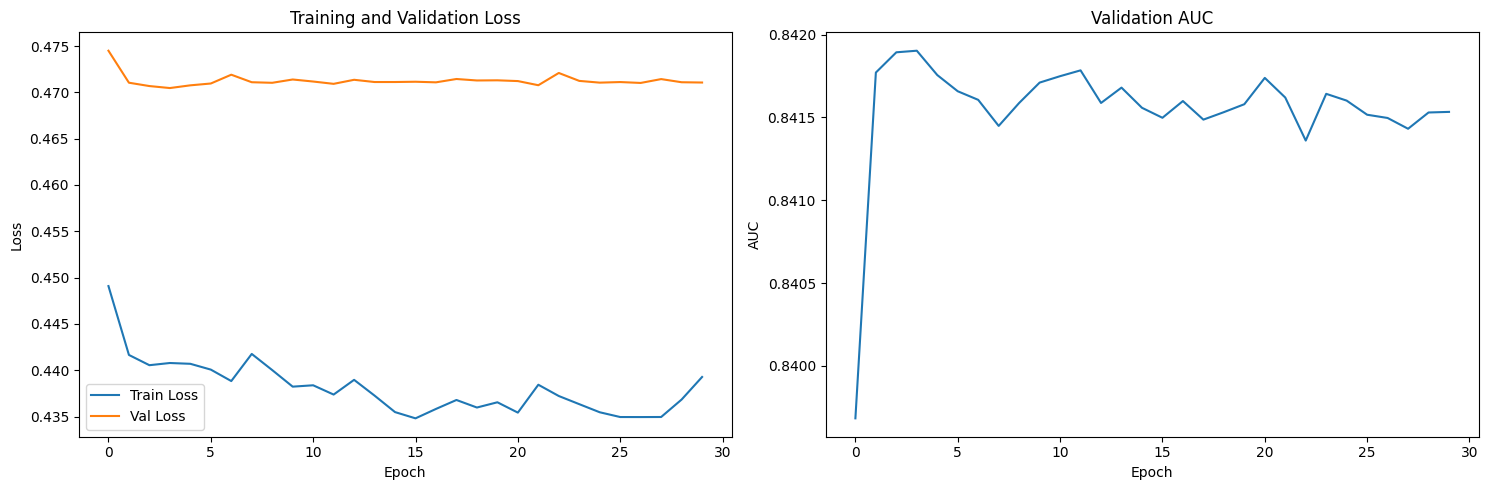

In [517]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_aucs)
plt.title('Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.tight_layout()
plt.show()

# Keep Track of evaluation metrics

Save eval metrics to a csv.

In [518]:
eval_metrics = {
    'Best Validation AUC': max(val_aucs),
    'Final Validation AUC': val_aucs[-1],
    'Best Training Loss': min(train_losses),
    'Final Training Loss': train_losses[-1],
    'Best Validation Loss': min(val_losses),
    'Final Validation Loss': val_losses[-1]
}
eval_df = pd.DataFrame(data=eval_metrics, index=[0]).describe()

eval_df.to_csv('./metrics/eval_metrics.csv', index=False)

In [519]:
def predict(model, scaler, features, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    features_scaled = scaler.transform(features)
    features_tensor = torch.FloatTensor(features_scaled).to(device)
    
    model.eval()
    with torch.no_grad():
        # Get raw logits from model
        logits = model(features_tensor)
        # Convert to probabilities using sigmoid
        probabilities = torch.sigmoid(logits)
    
    return probabilities.cpu().numpy()

In [520]:
# Example prediction
# 10 is a pass play
sample_play = X.iloc[[10]]
pred = predict(model, scaler, sample_play)
print(f"play: {sample_play}")
print(f"Probability of pass: {pred[0][0]:.3f}")

play:     down_1  down_2  down_3  down_4  yardsToGo  absoluteYardlineNumber  \
10   False   False    True   False          8                      29   

    quarter_1  quarter_2  quarter_3  quarter_4  ...  complex_formation  \
10       True      False      False      False  ...               True   

    RB_count  TE_count  WR_count  FB_count  heavy_package  spread_formation  \
10         1         1         3         0          False              True   

    te_wr_ratio  goal_line  short_yardage  
10         0.25      False          False  

[1 rows x 74 columns]
Probability of pass: 0.969


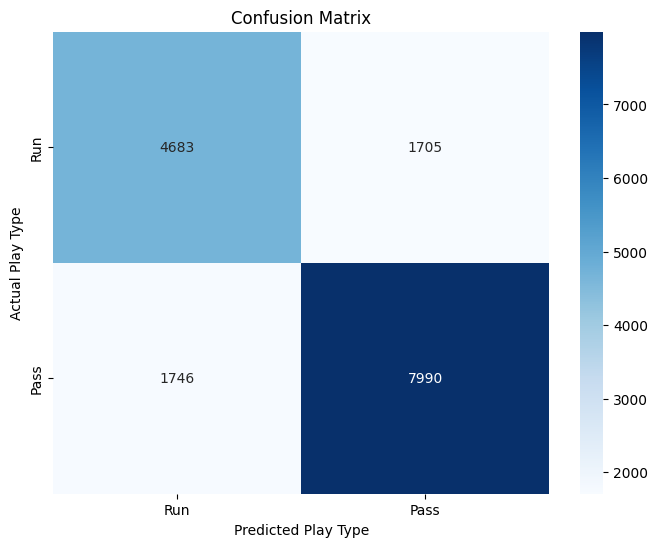

In [521]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_proba = predict(model, scaler, X)[:, 0]
y_true = y.values 

y_pred = (y_pred_proba > 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Play Type')
plt.xlabel('Predicted Play Type')

# Add custom labels
tick_labels = ['Run', 'Pass']
plt.gca().set_xticklabels(tick_labels)
plt.gca().set_yticklabels(tick_labels)

plt.show()

Average Precision Score: 0.914


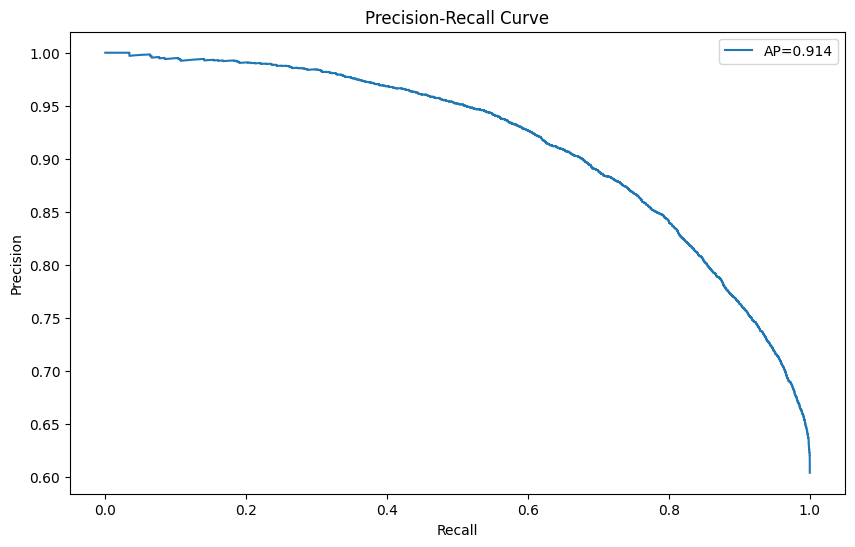

In [522]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate various metrics
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
ap = average_precision_score(y_true, y_pred_proba)

print(f"Average Precision Score: {ap:.3f}")

# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'AP={ap:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [523]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      6388
           1       0.82      0.82      0.82      9736

    accuracy                           0.79     16124
   macro avg       0.78      0.78      0.78     16124
weighted avg       0.79      0.79      0.79     16124



In [388]:
import shap
model.eval()

# Create background dataset from training data
background = torch.FloatTensor(scaler.transform(X[:1000])).to(device)
test_targets = torch.FloatTensor(scaler.transform(X[:1000])).to(device)

# Create explainer using background data
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_targets, check_additivity=False)

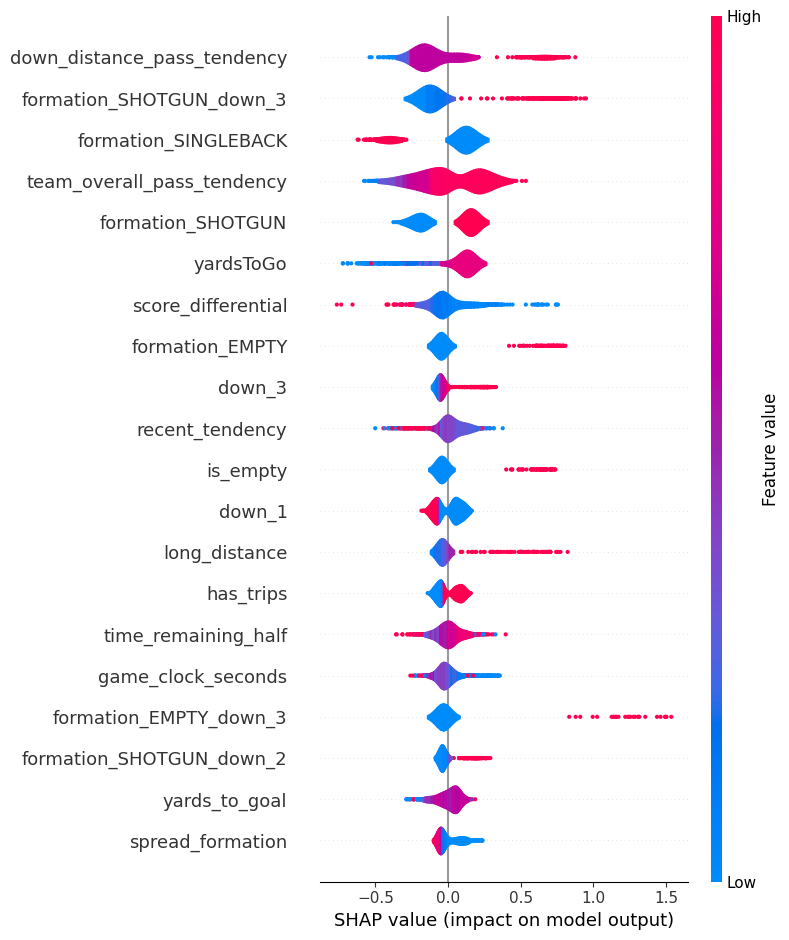

In [389]:
# Create plots
plt.figure(figsize=(15, 10))
shap.summary_plot(shap_values.squeeze(), test_targets.cpu().numpy(), 
                  feature_names=X.columns.tolist(), plot_type='violin')

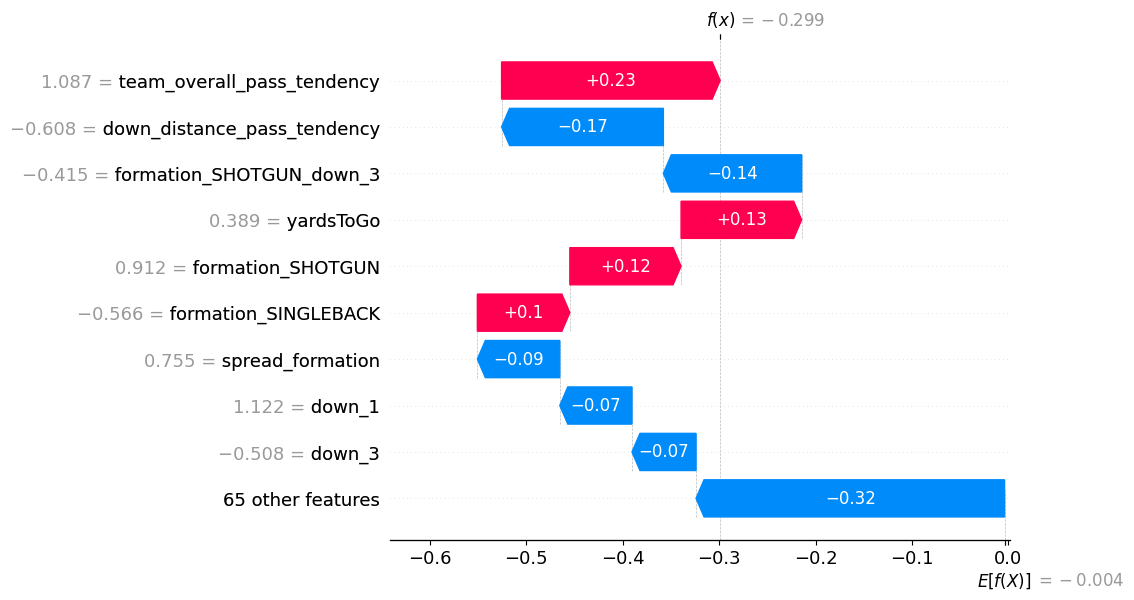

In [390]:
# Calculate base value and get first few predictions
base_value = shap_values[0].mean()
shap_values_few = shap_values[0][:1]  

e = shap.Explainer(model, shap_values.squeeze())

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values.squeeze()[0],
        base_values=base_value,
        data=test_targets[0].cpu().numpy(),
        feature_names=X.columns.tolist()
    ),
    show=False
)
plt.show()
